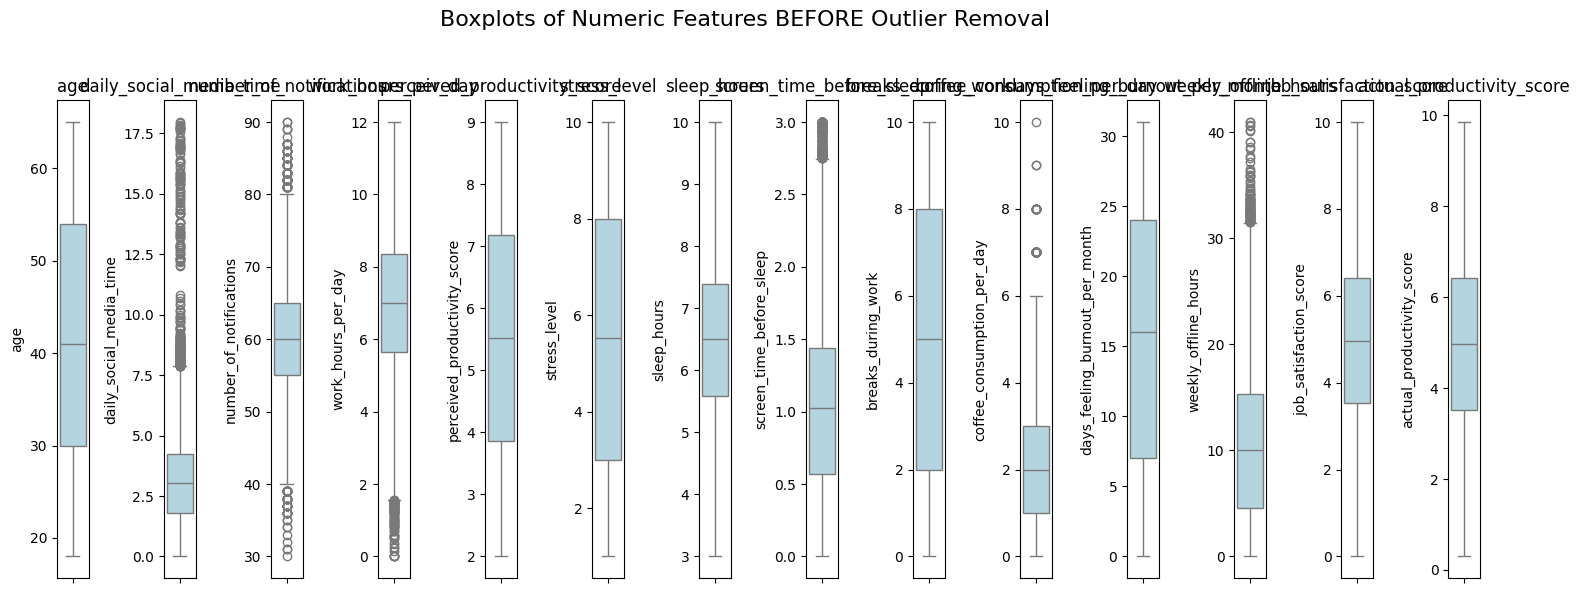

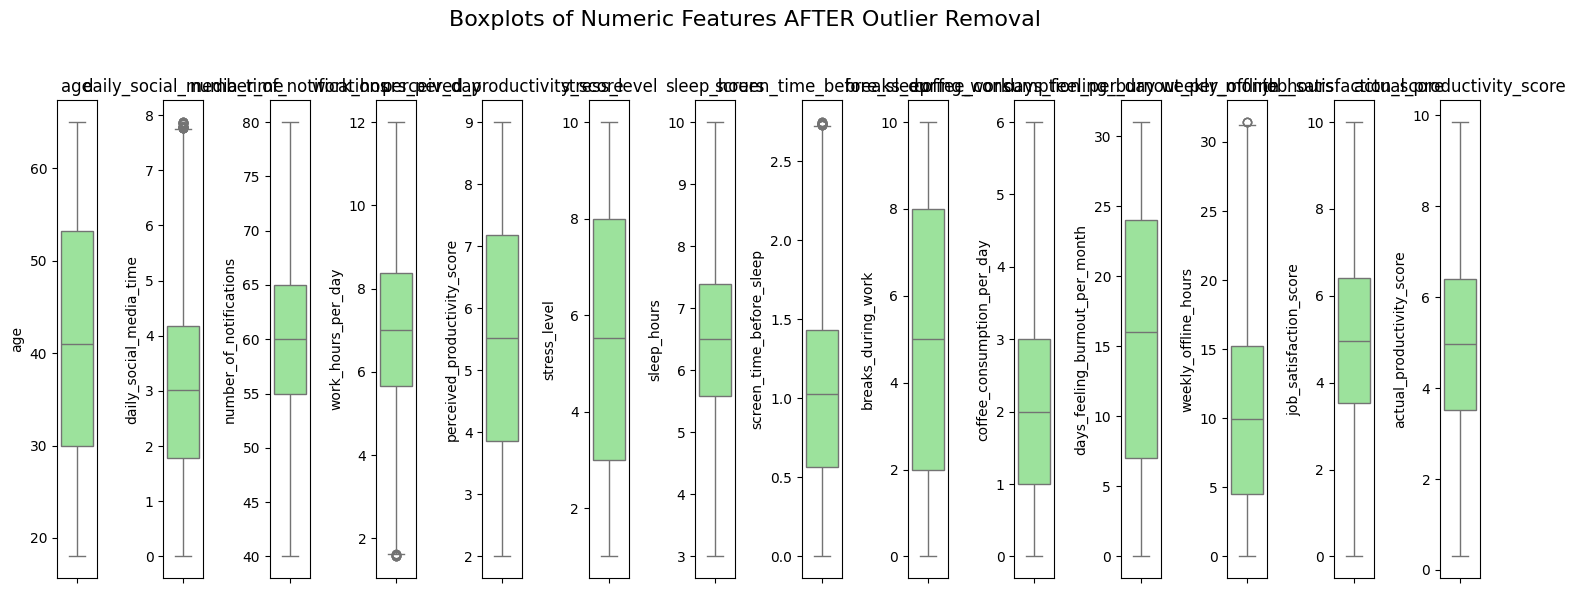

Bin:  [0.29847571 4.09721222 5.83370539 9.84625801]


<ipython-input-4-1645559737>:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='Set2')


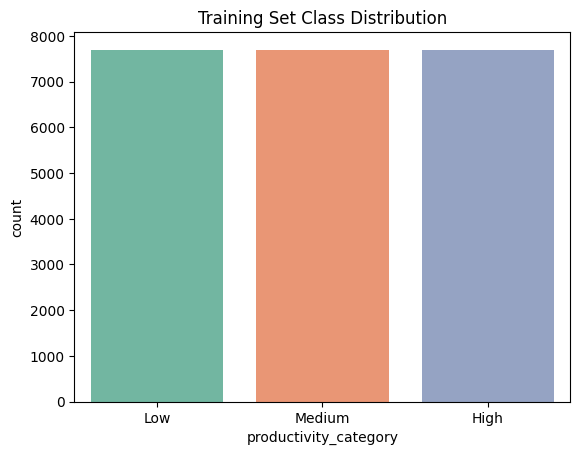

age: mean=41.5011, variance=191.9205, std_dev=13.8535
daily_social_media_time: mean=3.0136, variance=3.0450, std_dev=1.7450
number_of_notifications: mean=59.8543, variance=55.7567, std_dev=7.4670
work_hours_per_day: mean=7.0090, variance=3.8793, std_dev=1.9696
perceived_productivity_score: mean=5.5159, variance=3.8746, std_dev=1.9684
stress_level: mean=5.5384, variance=7.7018, std_dev=2.7752
sleep_hours: mean=6.4957, variance=1.9611, std_dev=1.4004
screen_time_before_sleep: mean=1.0152, variance=0.3789, std_dev=0.6155
breaks_during_work: mean=4.9861, variance=10.1278, std_dev=3.1824
coffee_consumption_per_day: mean=1.9644, variance=1.8717, std_dev=1.3681
days_feeling_burnout_per_month: mean=15.5243, variance=85.6387, std_dev=9.2541
weekly_offline_hours: mean=10.2629, variance=50.9579, std_dev=7.1385
job_satisfaction_score: mean=4.9669, variance=4.0905, std_dev=2.0225
🔍 Selected Features with SelectKBest (k=5) :
 - perceived_productivity_score
 - job_satisfaction_score
 - gender_Other
 

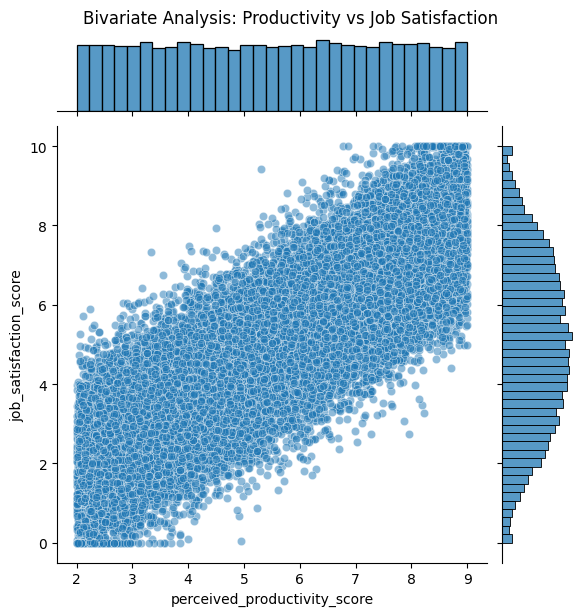

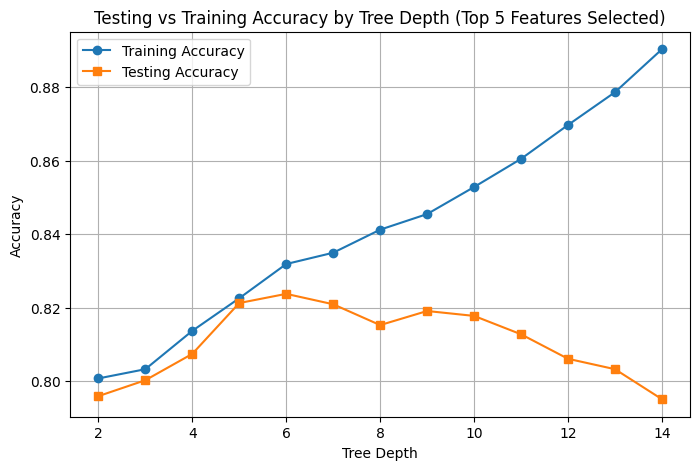

✅ Training Accuracy: 0.8319
✅ Testing Accuracy:  0.8238


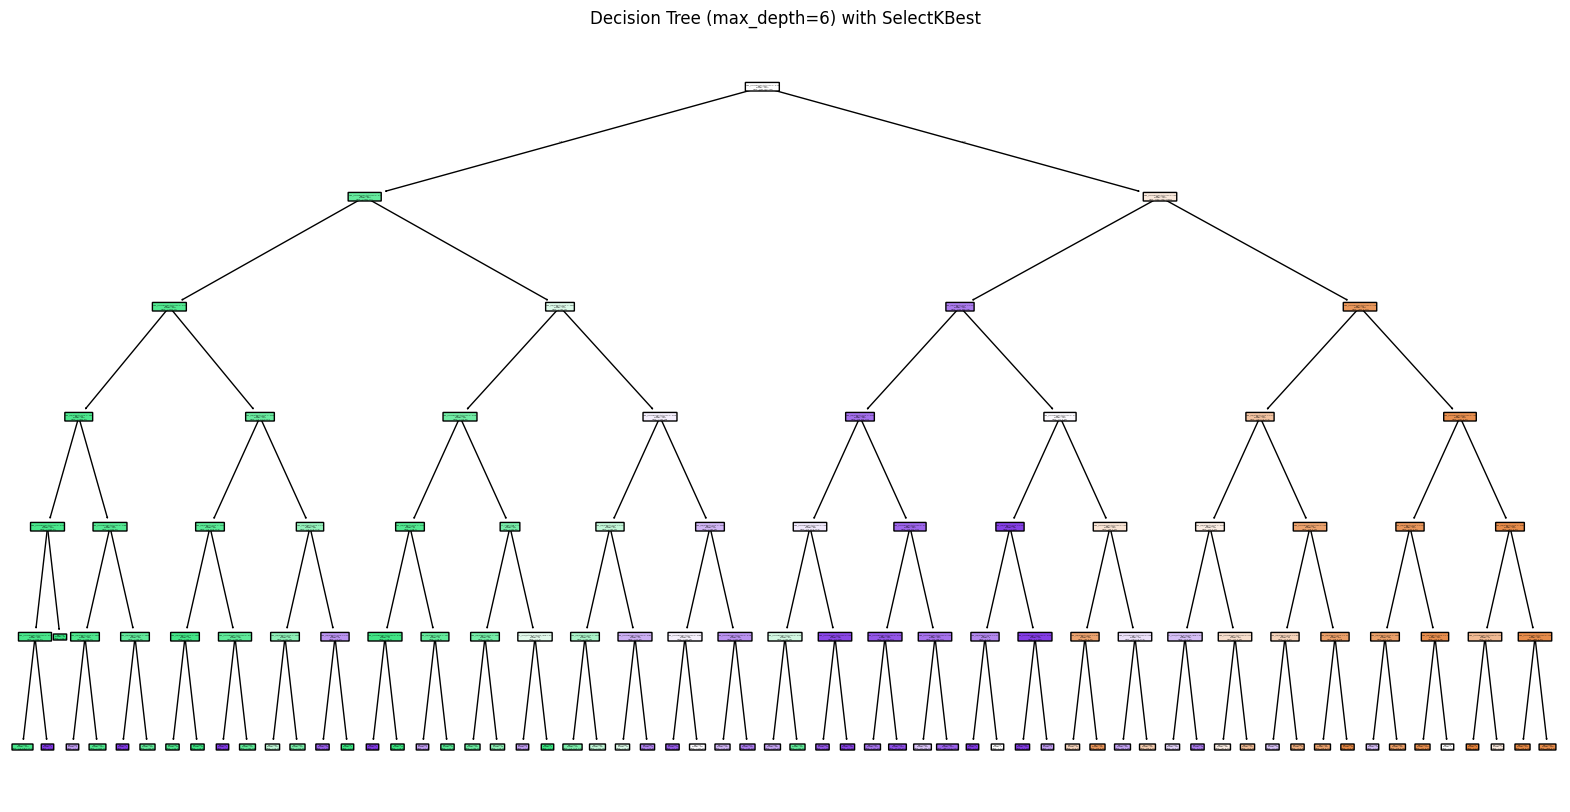

🧮 Gini impurity for root node (y_train): 0.6667

📊 Classification Report:
              precision    recall  f1-score   support

        High       0.85      0.88      0.86      1961
         Low       0.87      0.88      0.88      2030
      Medium       0.75      0.71      0.73      2008

    accuracy                           0.82      5999
   macro avg       0.82      0.82      0.82      5999
weighted avg       0.82      0.82      0.82      5999



<Figure size 600x600 with 0 Axes>

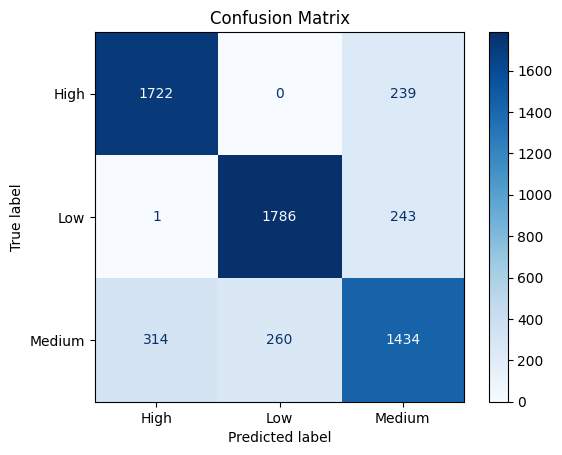

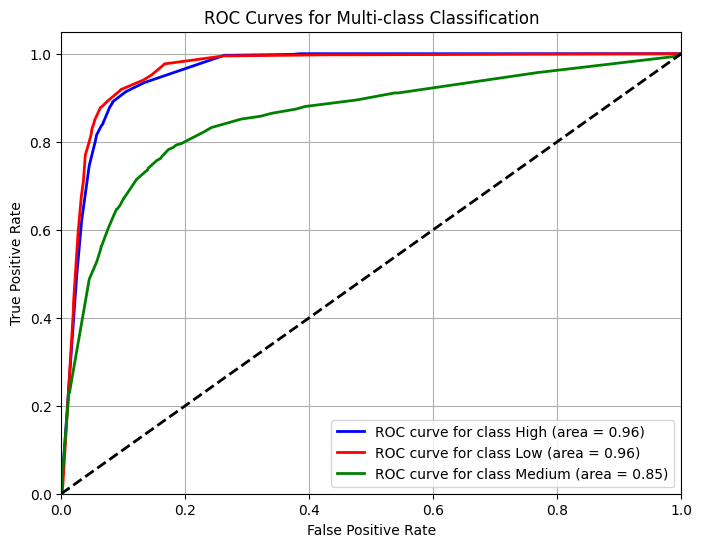

🧮 Entropy for root node (y_train): 1.5850
✅ [SVM] Training Accuracy: 0.8173
✅ [SVM] Testing Accuracy:  0.8178

📊 [SVM] Classification Report:
              precision    recall  f1-score   support

        High       0.84      0.88      0.86      1961
         Low       0.86      0.89      0.87      2030
      Medium       0.75      0.69      0.72      2008

    accuracy                           0.82      5999
   macro avg       0.82      0.82      0.82      5999
weighted avg       0.82      0.82      0.82      5999



<Figure size 600x600 with 0 Axes>

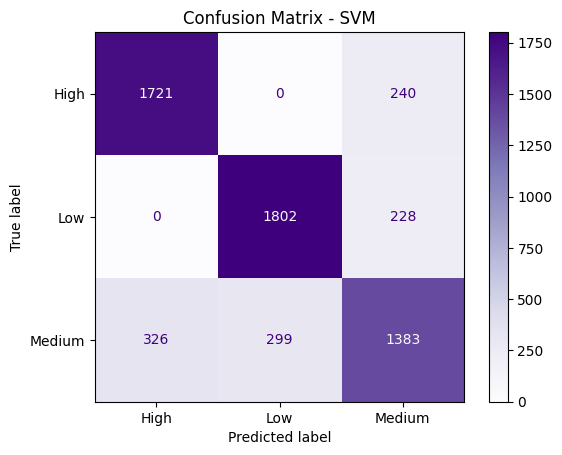

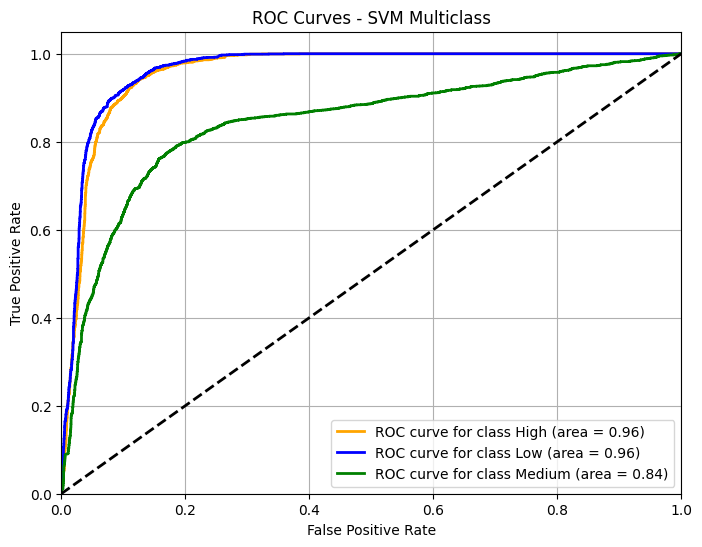

In [4]:
# --------------------------------------------
# 🔧 System & Core Libraries
# --------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# --------------------------------------------
# 📊 Scikit-learn (Data Preprocessing, Modeling, Evaluation)
# --------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
# --------------------------------------------
# 🧠 TensorFlow / Keras for Deep Learning
# --------------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# --------------------------------------------
# 🔌 SciKeras (Keras wrapper for sklearn)
# --------------------------------------------
!pip install scikeras[tensorflow]  # Only needed once
from scikeras.wrappers import KerasClassifier

# --------------------------------------------
# 📊 Visualization / Utility
# --------------------------------------------
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

from tensorflow.keras.utils import plot_model
from IPython.display import Image

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree


# Load dataset
social_df = pd.read_csv("social_media_vs_productivity.csv")





# -------------------------------
# 1. Split Data FIRST to prevent leakage
# -------------------------------
X = social_df.drop(columns=['actual_productivity_score'])  # keep score aside temporarily
y_score = social_df['actual_productivity_score']

X_train_raw, X_test_raw, y_score_train, y_score_test = train_test_split(
    X, y_score, test_size=0.2, random_state=42
)

# Reattach for easier processing
train_df = X_train_raw.copy()
train_df['actual_productivity_score'] = y_score_train

test_df = X_test_raw.copy()
test_df['actual_productivity_score'] = y_score_test

# -------------------------------
# 2. Handle missing values (based on training data)
# -------------------------------
missing_cols = [
    'daily_social_media_time', 'perceived_productivity_score', 'actual_productivity_score',
    'stress_level', 'sleep_hours', 'screen_time_before_sleep', 'job_satisfaction_score'
]

# Fill train
for col in missing_cols:
    skewness = train_df[col].skew()
    if abs(skewness) < 0.5:
        train_df[col] = train_df[col].fillna(train_df[col].mean())
    else:
        train_df[col] = train_df[col].fillna(train_df[col].median())

# Fill test using train stats
for col in missing_cols:
    skewness = train_df[col].skew()
    if abs(skewness) < 0.5:
        test_df[col] = test_df[col].fillna(train_df[col].mean())
    else:
        test_df[col] = test_df[col].fillna(train_df[col].median())

# -------------------------------
# 3. Remove outliers from training set only
# -------------------------------

numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 📊 Boxplots BEFORE outlier removal
plt.figure(figsize=(15, 6))
plt.suptitle("Boxplots of Numeric Features BEFORE Outlier Removal", fontsize=16)
for i, col in enumerate(numeric_cols):
    plt.subplot(1, len(numeric_cols), i + 1)
    sns.boxplot(y=train_df[col], color='lightblue')
    plt.title(col)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Q1 = train_df[numeric_cols].quantile(0.25)
Q3 = train_df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

non_outliers_mask = ~((train_df[numeric_cols] < lower_bound) | (train_df[numeric_cols] > upper_bound)).any(axis=1)
train_df_clean = train_df[non_outliers_mask].reset_index(drop=True)

# 📊 Boxplots AFTER outlier removal
plt.figure(figsize=(15, 6))
plt.suptitle("Boxplots of Numeric Features AFTER Outlier Removal", fontsize=16)
for i, col in enumerate(numeric_cols):
    plt.subplot(1, len(numeric_cols), i + 1)
    sns.boxplot(y=train_df_clean[col], color='lightgreen')
    plt.title(col)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# -------------------------------
# 4. Categorize productivity
# -------------------------------
train_df_clean['productivity_category'], bins = pd.qcut(
    train_df_clean['actual_productivity_score'], q=3,
    labels=['Low', 'Medium', 'High'], retbins=True
)
print("Bin: ",bins)
# Apply same bins to test set
test_df['productivity_category'] = pd.cut(
    test_df['actual_productivity_score'],
    bins=bins,
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)
test_df_clean = test_df.dropna(subset=['productivity_category']).reset_index(drop=True)

# -------------------------------
# 5. Define features and target
# -------------------------------
X_train = train_df_clean.drop(columns=['actual_productivity_score', 'productivity_category'])
y_train = train_df_clean['productivity_category']

X_test = test_df_clean.drop(columns=['actual_productivity_score', 'productivity_category'])
y_test = test_df_clean['productivity_category']

# -------------------------------
# 6. Check class balance
# -------------------------------
sns.countplot(x=y_train, palette='Set2')
plt.title("Training Set Class Distribution")
plt.show()

# -------------------------------
# 7. Preprocessing pipeline
# -------------------------------
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])




# -------------------------------
# 8. Fit-transform train / transform test
# -------------------------------
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
# After fitting
scaler = preprocessor.named_transformers_['num']

# Means and variances for numeric features
means = scaler.mean_
vars_ = scaler.var_
stds = scaler.scale_

for feature, mean, var, std in zip(numeric_features, means, vars_, stds):
    print(f"{feature}: mean={mean:.4f}, variance={var:.4f}, std_dev={std:.4f}")


le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)




# -------------------------------
# 9. Feature selection with SelectKBest
# -------------------------------

selector = SelectKBest(score_func=f_classif, k=5)
selector.fit(X_train_processed, y_train_enc)

X_train_selected = selector.transform(X_train_processed)
X_test_selected = selector.transform(X_test_processed)


num_features_names = numeric_features
cat_features_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
all_feature_names = num_features_names + cat_features_names

# Features sélectionnées
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = [all_feature_names[i] for i in selected_feature_indices]

print("🔍 Selected Features with SelectKBest (k=5) :")
for feat in selected_feature_names:
    print(f" - {feat}")


import seaborn as sns
import matplotlib.pyplot as plt

sns.jointplot(
    data=social_df,
    x='perceived_productivity_score',
    y='job_satisfaction_score',
    kind='scatter',  # or 'kde', 'hex' for other views
    alpha=0.5
)

plt.suptitle("Bivariate Analysis: Productivity vs Job Satisfaction", y=1.02)
plt.show()
# -------------------------------
# 6. Build and Train Model, Neural network
# -------------------------------








input_dim = X_train_selected.shape[1]
num_classes = len(np.unique(y_train))
import numpy as np
from tensorflow.keras.callbacks import Callback
def create_model():
    model = Sequential([
        InputLayer(input_shape=(input_dim,)),
        Dense(64, activation='relu'),   # 1st hidden layer
        Dense(64, activation='relu'),   # 2nd hidden layer (added)
        Dense(64, activation='relu'),   # 3rd hidden layer
        Dense(64, activation='relu'),   # 4th hidden layer (added)
        Dense(num_classes, activation='softmax')
    ])
    model.summary()

    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model


neuron_weights = []
class AllLayersNeuronLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}:")
        dense_layers = [layer for layer in self.model.layers if isinstance(layer, Dense)]
        for i, layer in reversed(list(enumerate(dense_layers, start=1))):
            weights = layer.get_weights()[0][:, 0]
            print(f"Layer {i} (backward): Neuron 0 first 5 weights: {weights[:5]}")



model = KerasClassifier(
    model=create_model,
    epochs=30,
    batch_size=10,
    verbose=2,
    callbacks=[AllLayersNeuronLogger()]
)


model.fit(
    X_train_selected,
    y_train,
    validation_split=0.2,
    verbose=1,

)


test_loss, test_acc = model.model_.evaluate(X_test_selected, y_test_enc, verbose=2)
print(test_loss)
print(test_acc)



metrics_df = pd.DataFrame(model.history_)
metrics_df[["loss","val_loss"]].plot();
metrics_df[["accuracy","val_accuracy"]].plot();
plt.show()
#  Access the trained Keras model from Scikeras
trained_keras_model = model.model_

#  Ensure the model is built
sample_input_np = X_train_selected[:1]
_ = trained_keras_model(tf.convert_to_tensor(sample_input_np, dtype=tf.float32))

#  Capture initial weights before backward pass
initial_weights = [var.numpy().copy() for var in trained_keras_model.trainable_variables]

#  Backward pass: compute gradients
sample_input_tf = tf.convert_to_tensor(sample_input_np, dtype=tf.float32)
sample_label_np = np.array([y_train_enc[0]])
sample_label_tf = tf.convert_to_tensor(sample_label_np, dtype=tf.int32)

with tf.GradientTape() as tape:
    prediction = trained_keras_model(sample_input_tf, training=True)
    loss_fn = SparseCategoricalCrossentropy()
    loss_value = loss_fn(sample_label_tf, prediction)

# Compute gradients
gradients = tape.gradient(loss_value, trained_keras_model.trainable_variables)

#  Apply gradients manually to simulate a weight update
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
optimizer.apply_gradients(zip(gradients, trained_keras_model.trainable_variables))



 #7️⃣ Forward pass after weight update
 #Collect Dense layer outputs
model_inputs = trained_keras_model.inputs
layer_outputs = [layer.output for layer in trained_keras_model.layers if isinstance(layer, tf.keras.layers.Dense)]
activation_model = Model(inputs=model_inputs, outputs=layer_outputs)

# Forward pass
activations = activation_model.predict(sample_input_np)

print("🔍 Forward Propagation - Activations (After Weight Update)")
for i, activation in enumerate(activations):
    print(f"\n🔹 Layer {i+1} activation values:")
    print(activation[0])  # Print activations for the first sample



# -------------------------------
# 7. Evaluation
# -------------------------------
y_pred_train = model.predict(X_train_selected)
y_pred = model.predict(X_test_selected)

print("\n✅ Testing Accuracy: {:.2f}%".format(model.score(X_test_selected, y_test) * 100))
print("\n✅ Training Accuracy: {:.2f}%".format(model.score(X_train_selected, y_train) * 100))
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))
print("🧩 Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


keras_model = create_model()
plot_model(keras_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
display(Image('model_plot.png'))


# 17. ROC and AUC for multiclass
y_test_bin = label_binarize(y_test_enc, classes=np.arange(num_classes))
y_proba = model.predict_proba(X_test_selected)

plt.figure(figsize=(8,6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of class {le.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()




#  Apply PCA to reduce from 5 features to 2
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_processed)  # X_train_processed shape: (n_samples, 5)

#  Define a new model that accepts 2 input features
input_dim_2 = 2
num_classes = len(set(y_train))  # Number of classes

def create_model_2features(units=64, learning_rate=0.001):
    model = Sequential([
        Input(shape=(input_dim_2,)),
        Dense(64, activation='relu'),   # 1st hidden layer
        Dense(64, activation='relu'),   # 2nd hidden layer (added)
        Dense(64, activation='relu'),   # 3rd hidden layer
        Dense(64, activation='relu'),   # 4th hidden layer (added)
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

#  Wrap the model with KerasClassifier
keras_model_2 = KerasClassifier(
    model=create_model_2features,
     epochs=30,
    batch_size=10,
    verbose=0
)

#  Train on PCA-reduced data
keras_model_2.fit(X_train_pca, y_train_enc)


#  Plot decision regions on PCA-reduced data
plt.figure(figsize=(8,6))
plot_decision_regions(X_train_pca, y_train_enc, clf=keras_model_2, legend=2)

plt.title('Decision Regions on PCA-Reduced Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


selected_features2 = ['perceived_productivity_score', 'job_satisfaction_score', 'social_platform_preference', 'job_type','gender']

df_encoded = social_df[selected_features2].copy()
for col in ['social_platform_preference', 'job_type', 'gender']:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes




if len(numeric_features) >= 4:
    plt.figure(figsize=(10, 8))
    corr = social_df[numeric_features].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()






#############Decision tree

# Fonction Gini impurity-->Calcule l’impureté de Gini pour un ensemble de labels-->Plus proche de 0 = pur.
def gini_impurity(labels):
    total = len(labels)
    if total == 0:
        return 0
    counts = Counter(labels)
    impurity = 1.0
    for count in counts.values():
        prob = count / total
        impurity -= prob ** 2
    return impurity
#Analyse précision en fonction de la profondeur d’arbre avec SelectKBest
depths = range(2, 15)
train_accs = []#pour stocker les accuracy sur les ensembles d'entraînement et de test.
test_accs = []
k=5
for depth in depths:
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif, k=k)),
        ('classifier', DecisionTreeClassifier(max_depth=depth, random_state=42))#classifieur DT limité à la profondeur depth
    ])
    pipe.fit(X_train, y_train)#Entraîne tout le pipeline sur X_train et y_train
    train_accs.append(accuracy_score(y_train, pipe.predict(X_train)))
    test_accs.append(accuracy_score(y_test, pipe.predict(X_test)))

plt.figure(figsize=(8, 5))
plt.plot(depths, train_accs, marker='o', label='Training Accuracy')
plt.plot(depths, test_accs, marker='s', label='Testing Accuracy')
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title(f"Testing vs Training Accuracy by Tree Depth (Top {k} Features Selected)")
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Entraînement final avec max_depth=6 ---
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=k)),
    ('classifier', DecisionTreeClassifier(max_depth=6, random_state=42))#par defaut:criterion='gini'
])
pipeline.fit(X_train, y_train)

# Prédictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Affichage des accuracies
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"✅ Training Accuracy: {train_acc:.4f}")
print(f"✅ Testing Accuracy:  {test_acc:.4f}")

#Affichage de l’arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(
    pipeline.named_steps['classifier'],
    filled=True,
    feature_names=pipeline.named_steps['feature_selection'].get_feature_names_out(
        pipeline.named_steps['preprocessor'].get_feature_names_out()
    ),
    class_names=pipeline.named_steps['classifier'].classes_,
    rounded=True
)
plt.title("Decision Tree (max_depth=6) with SelectKBest")
plt.show()

# --- 5. Calcul et affichage de l’impureté de Gini pour le nœud racine--> se fait pour training set
gini_train = gini_impurity(y_train)
print(f"🧮 Gini impurity for root node (y_train): {gini_train:.4f}")

# --- 6. Rapport de classification et matrice de confusion ---
print("\n📊 Classification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=pipeline.named_steps['classifier'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.named_steps['classifier'].classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Classes dans le bon ordre
classes = pipeline.named_steps['classifier'].classes_

# Binariser les labels true (test)
y_test_bin = label_binarize(y_test, classes=classes)

# Probabilités prédites par le modèle (sur test)
y_score = pipeline.predict_proba(X_test)

# Calcul des courbes ROC et AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # ligne diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#calcul de l'entropy
import math

def entropy(labels):
    total = len(labels)
    if total == 0:
        return 0
    counts = Counter(labels)
    ent = 0.0
    for count in counts.values():
        prob = count / total
        ent -= prob * math.log2(prob)
    return ent
ent_train = entropy(y_train)
print(f"🧮 Entropy for root node (y_train): {ent_train:.4f}")

####SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Pipeline SVM ---
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=5)),  # k à adapter si besoin
    ('classifier', SVC(kernel='rbf', probability=True, random_state=42))  # 'rbf' par défaut, avec proba pour ROC
])

# --- Entraînement ---
svm_pipeline.fit(X_train, y_train)

# --- Prédictions ---
y_train_pred_svm = svm_pipeline.predict(X_train)
y_test_pred_svm = svm_pipeline.predict(X_test)

# --- Accuracies ---
train_acc_svm = accuracy_score(y_train, y_train_pred_svm)
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)

print(f"✅ [SVM] Training Accuracy: {train_acc_svm:.4f}")
print(f"✅ [SVM] Testing Accuracy:  {test_acc_svm:.4f}")

print("\n📊 [SVM] Classification Report:")
print(classification_report(y_test, y_test_pred_svm))

cm_svm = confusion_matrix(y_test, y_test_pred_svm, labels=svm_pipeline.named_steps['classifier'].classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_pipeline.named_steps['classifier'].classes_)

plt.figure(figsize=(6, 6))
disp_svm.plot(cmap='Purples', values_format='d')
plt.title("Confusion Matrix - SVM")
plt.grid(False)
plt.show()

# Binariser les classes
y_test_bin_svm = label_binarize(y_test, classes=svm_pipeline.named_steps['classifier'].classes_)

# Probabilités
y_score_svm = svm_pipeline.predict_proba(X_test)

# ROC et AUC
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()

for i, cls in enumerate(svm_pipeline.named_steps['classifier'].classes_):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_bin_svm[:, i], y_score_svm[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# Plot
plt.figure(figsize=(8, 6))
colors = ['orange', 'blue', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr_svm[i], tpr_svm[i], color=color, lw=2,
             label=f'ROC curve for class {svm_pipeline.named_steps["classifier"].classes_[i]} (area = {roc_auc_svm[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - SVM Multiclass')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()